# Stock Price Perdiction

## Libraries

In [23]:
#Frequently Used Machine Learning All Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
from datetime import datetime
from sklearn.svm import SVR
import calendar
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import LSTM, Dense #type:ignore
from sklearn.preprocessing import MinMaxScaler


## Read Data

In [24]:
#Read Text File convert into DataFrame
read_data=pd.read_csv("NFLX.csv")
df=pd.DataFrame(read_data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


## Data Preprocessing

In [25]:
df.columns
'''
'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
'''

"\n'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'\n"

In [26]:
#DataFrame Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [27]:
#Describe All Numerical Column
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [28]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [29]:
df[df.duplicated()]
#No duplicates

,Date,Open,High,Low,Close,Adj Close,Volume


In [30]:
df.shape
#1009 Rows 7 Column

(1009, 7)

In [31]:
df['Date'] = pd.to_datetime(df["Date"])

## Data Visulization

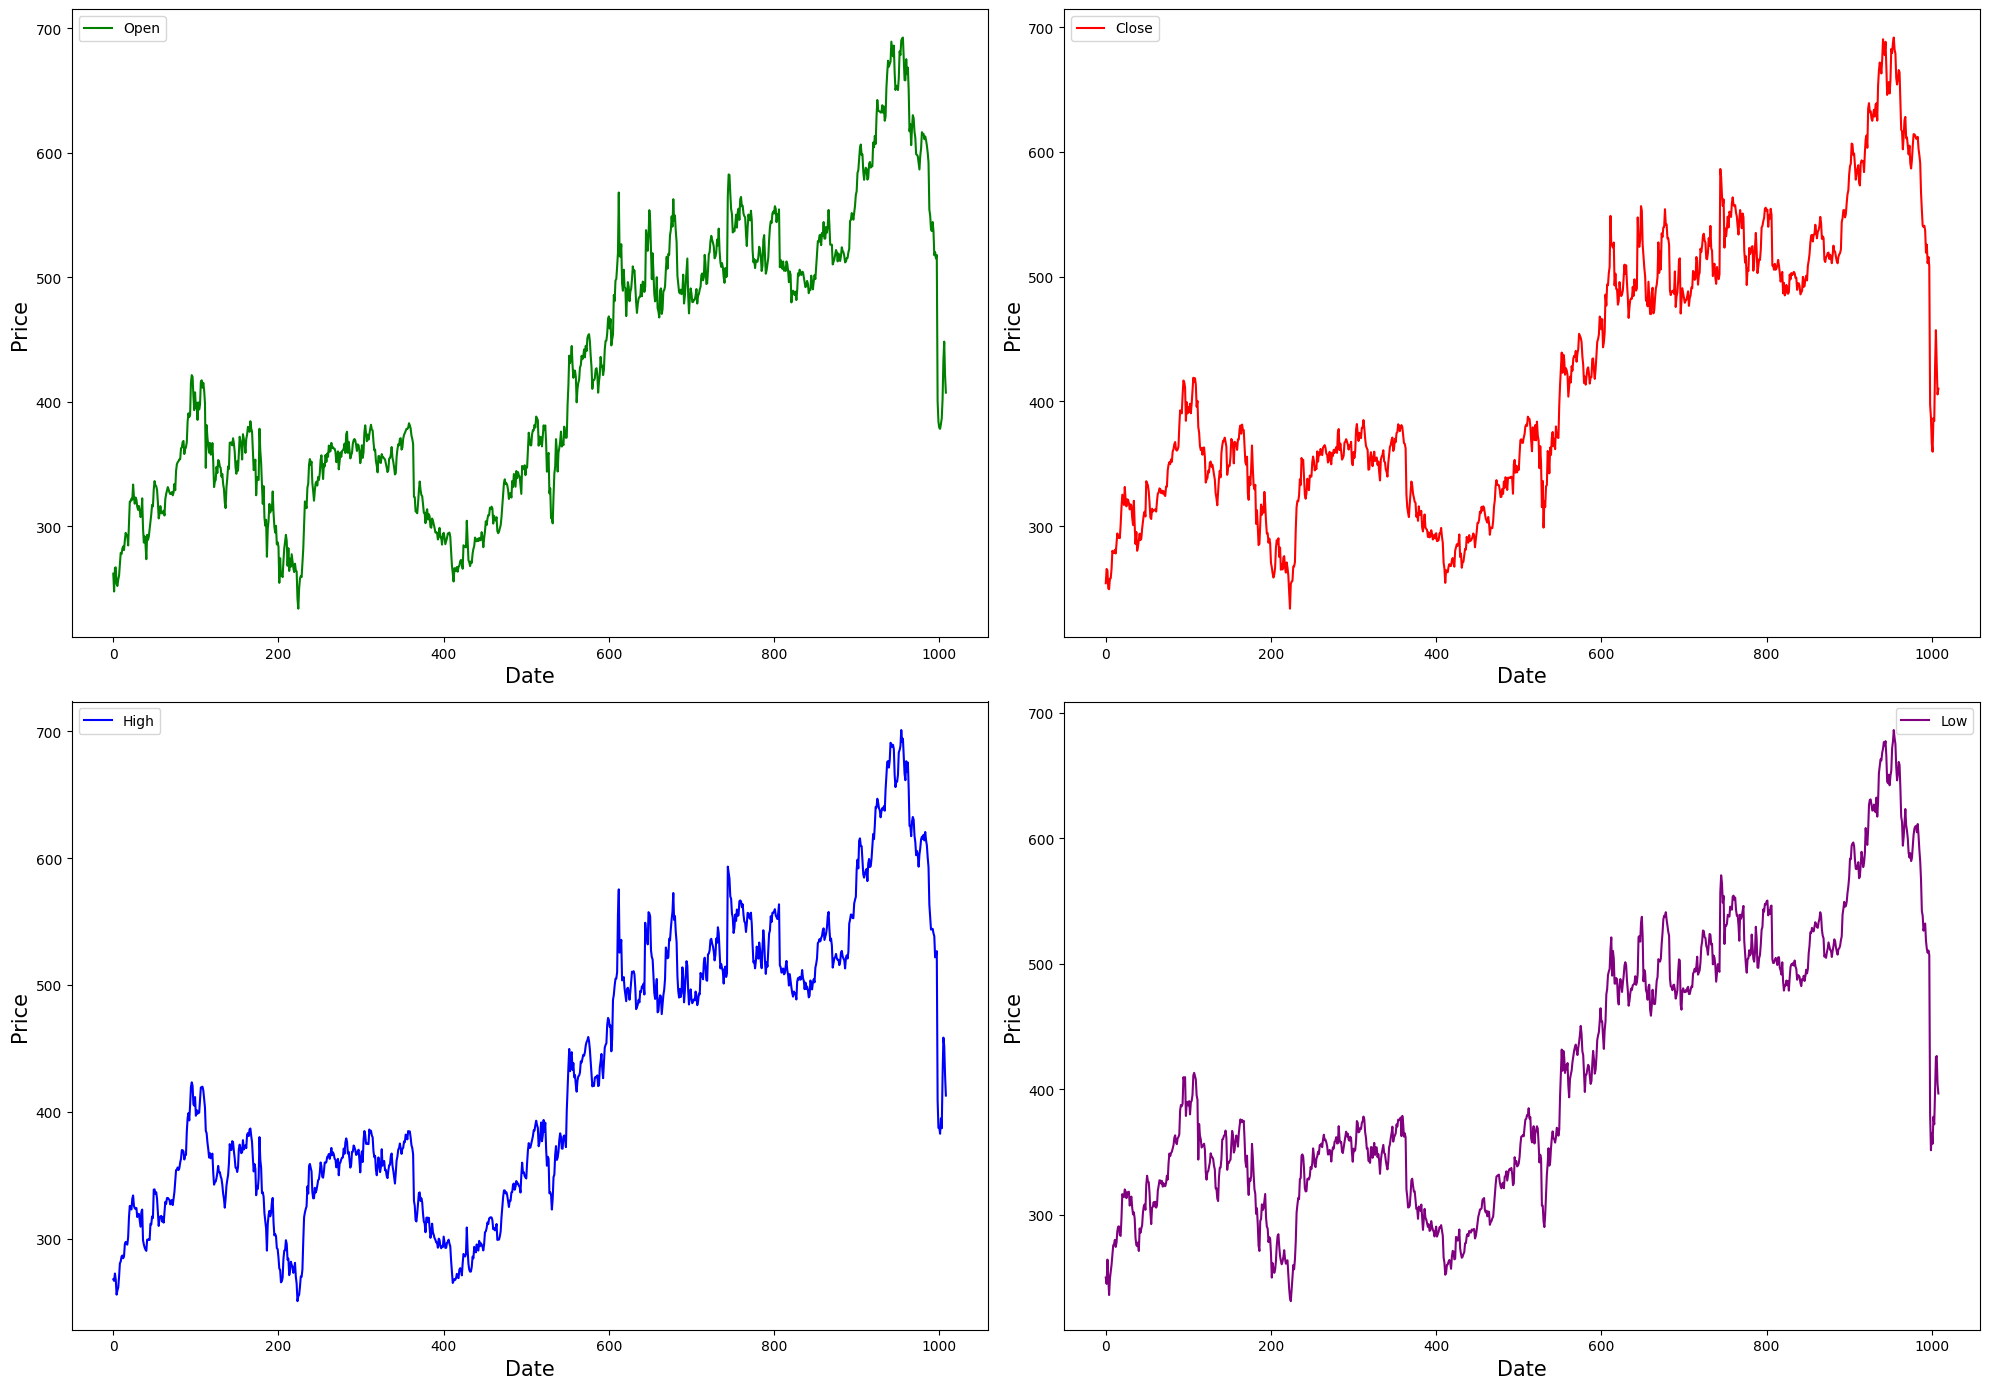

In [32]:
# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

axs[0, 0].plot(df['Open'], label='Open', color='green')
axs[0, 0].set_xlabel('Date', size=15)
axs[0, 0].set_ylabel('Price', size=15)
axs[0, 0].legend()

axs[0, 1].plot(df['Close'], label='Close', color='red')
axs[0, 1].set_xlabel('Date', size=15)
axs[0, 1].set_ylabel('Price', size=15)
axs[0, 1].legend()

axs[1, 0].plot(df['High'], label='High', color='blue')
axs[1, 0].set_xlabel('Date', size=15)
axs[1, 0].set_ylabel('Price', size=15)
axs[1, 0].legend()

axs[1, 1].plot(df['Low'], label='Low', color='purple')
axs[1, 1].set_xlabel('Date', size=15)
axs[1, 1].set_ylabel('Price', size=15)
axs[1, 1].legend()

plt.tight_layout()

plt.show()

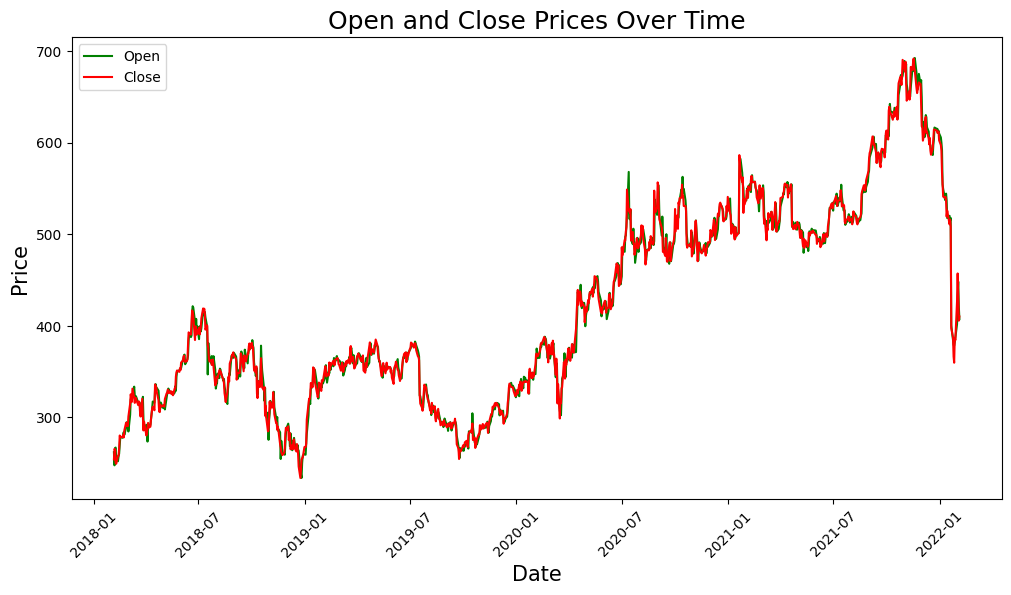

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'], df['Open'], label='Open', color='green')
plt.plot(df['Date'], df['Close'], label='Close', color='red')

plt.xlabel('Date', size=15)
plt.ylabel('Price', size=15)
plt.title('Open and Close Prices Over Time', size=18)

plt.legend()

plt.xticks(rotation=45)

# Show the plot
plt.show()

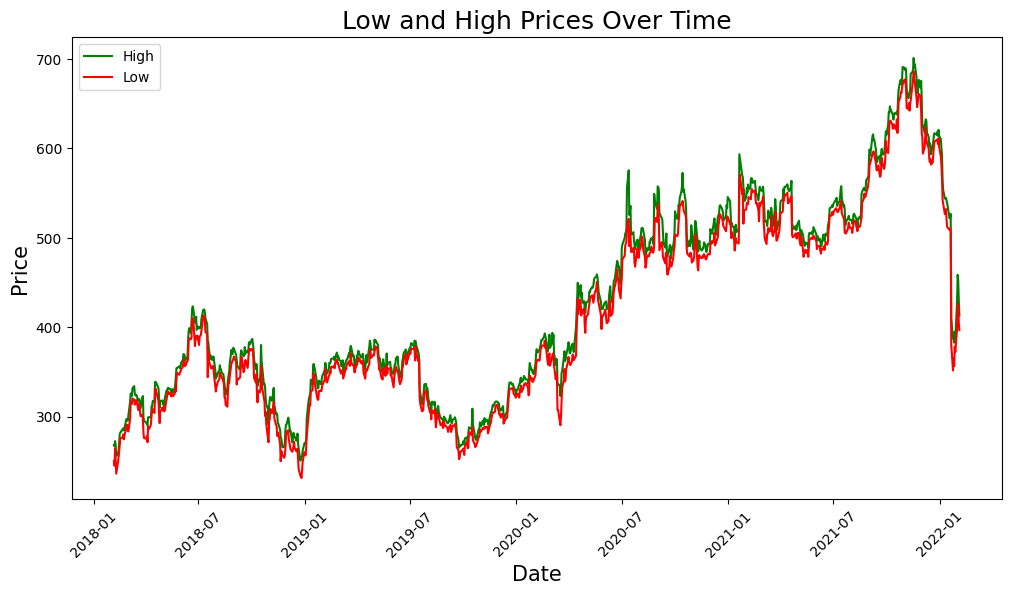

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'], df['High'], label='High', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')

plt.xlabel('Date', size=15)
plt.ylabel('Price', size=15)
plt.title('Low and High Prices Over Time', size=18)

plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

## Feature Engineering

In [35]:

numerical_features = ["Open","Close","High","Low"]
scaler_minmax = MinMaxScaler()
df[numerical_features] = scaler_minmax.fit_transform(df[numerical_features])

In [36]:
prices = df['Close'].values.reshape(-1, 1) #type:ignore

scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

## LSTM MOdel

In [37]:
#Save sequence of how many days we want
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [38]:
#Create Sequence 

sequence_length = 30
X, y = create_sequences(prices_scaled, sequence_length)

## Split Data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train LSTM Model

In [40]:
#LSTM sequence MOdel
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64,validation_data=(X_test, y_test))
predictions = model.predict(X_test)

Epoch 1/50
13/13 [==============================] - 2s 34ms/step - loss: 0.1937 - val_loss: 0.1193
Epoch 2/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0651 - val_loss: 0.0085
Epoch 3/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0117 - val_loss: 0.0073
Epoch 4/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0080 - val_loss: 0.0049
Epoch 5/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 8/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 9/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 11/

## Evaluate MOdel

In [41]:
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions_actual)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0016022953019332337


## Visualize Accuracy

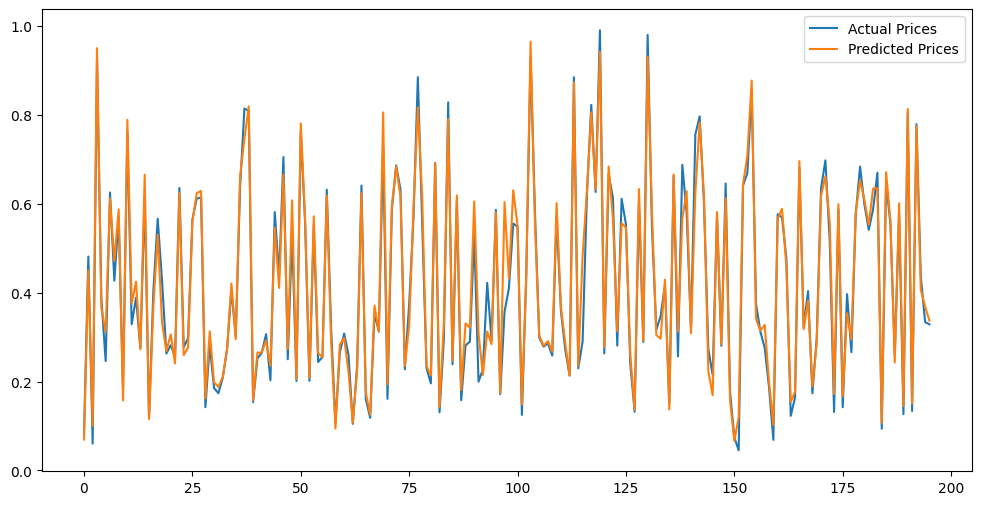

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions_actual, label='Predicted Prices')
plt.legend()
plt.show()

## Perdict Next 30 Days Stock`s Clsoing Price

In [43]:
# Predict the next 30 days Closing price 
future_days = 30
last_sequence = prices_scaled[-sequence_length:]
predictions = []

for _ in range(future_days):
    next_day = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(next_day[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_day

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 35ms/step


## Visulize Next 30 Days Closing Price

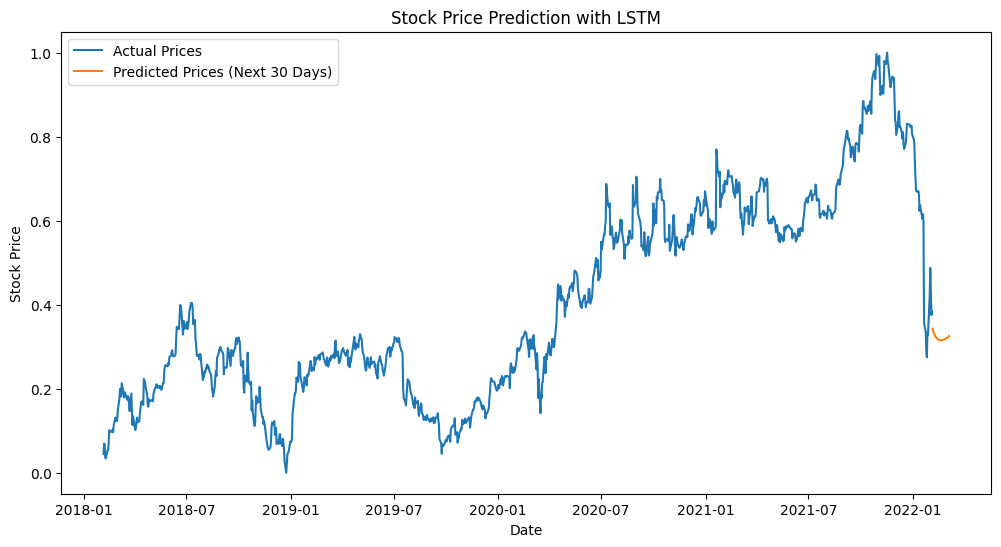

In [44]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
last_date = pd.to_datetime(df['Date'].iloc[-1])
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, future_days + 1)]

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Actual Prices')
plt.plot(future_dates, predictions, label='Predicted Prices (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()